In [5]:
# Data/Deidentified_studies/Vision_embeddings/
# Add/Deidentified_studeis_Add/Vision_embeddings/



# mlp_val - /mnt/storage/deva/BreastCancer_GeneticMutation/Deidentified_studies_Add/Deidentified_studeis_Add/Vision_embeddings/7720181_1.2.840.114350.2.451.2.798268.2.2222650484436.1_1.3.46.670589.62.1.32200.2022.5.23.19.41.54.861.2284.16768.pkl,0
# combined -/mnt/storage/deva/BreastCancer_GeneticMutation/Deidentified_studies_Add/Deidentified_studeis_Add/Vision_embeddings/13562847_1.2.840.114350.2.451.2.798268.2.2223023787182.1_1.3.46.670589.62.1.32200.2022.6.14.21.7.34.185.12888.pkl,0
 
import pandas as pd


def update_csv(input_file, output_file):
    # Read the CSV file
    df = pd.read_csv(input_file, header=None)

    # Update the paths
    def update_path(path):
        if "Data/Deidentified_studies/" in path:
            path = path.replace("Data/Deidentified_studies/", "Data/Deidentified_studies/Vision_embeddings/").replace(".nii.gz", ".pkl")
        if "Add/Deidentified_studeis_Add/" in path:
            path = path.replace("Add/Deidentified_studeis_Add/", "Add/Deidentified_studeis_Add/Vision_embeddings/").replace(".nii.gz", ".pkl")
        return path

    df[0] = df[0].apply(update_path)

    # Save the updated CSV to a new file
    df.to_csv(output_file, index=False, header=False)

# Paths to the input and output files
files = {
    "/mnt/storage/deva/Data/new_train_data.csv": "/mnt/storage/deva/Data/mlp_train.csv",
    "/mnt/storage/deva/Data/new_val_data.csv": "/mnt/storage/deva/Data/mlp_val.csv",
    "/mnt/storage/deva/Data/combined_test_data.csv": "/mnt/storage/deva/Data/mlp_test.csv"
}

# Update all CSV files
for input_file, output_file in files.items():
    update_csv(input_file, output_file)

print("CSV files updated successfully!")


CSV files updated successfully!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

/home/dravich6/miniconda3/envs/MedCT/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/tmp/i

Epoch [1/8], Train Loss: 0.6722, Test Loss: 0.6293
Epoch [2/8], Train Loss: 0.5527, Test Loss: 0.6009
Epoch [3/8], Train Loss: 0.5091, Test Loss: 0.5473
Epoch [4/8], Train Loss: 0.4842, Test Loss: 0.5586
Epoch [5/8], Train Loss: 0.4744, Test Loss: 0.5334
Epoch [6/8], Train Loss: 0.4625, Test Loss: 0.5547
Epoch [7/8], Train Loss: 0.4602, Test Loss: 0.5300
Epoch [8/8], Train Loss: 0.4554, Test Loss: 0.5327
Test accuracy: 73.88%


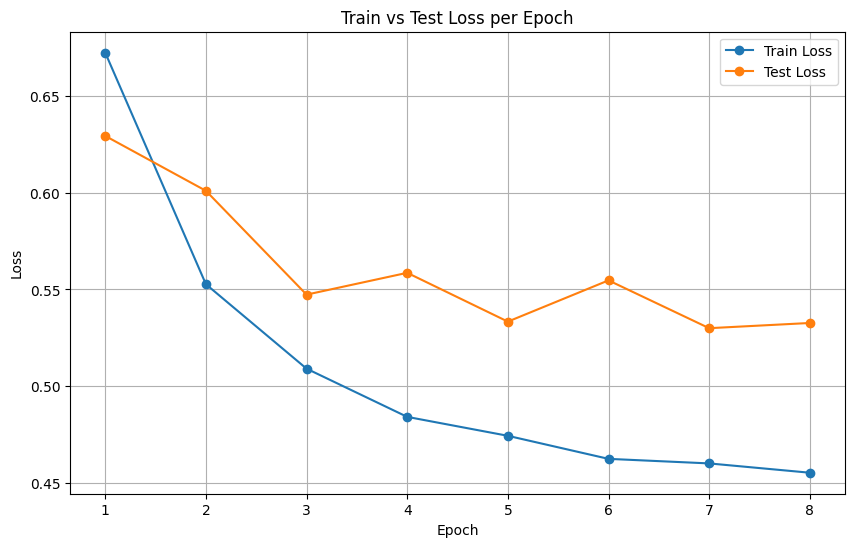


Epoch-wise Loss Values:
Epoch 1: Train Loss = 0.6722, Test Loss = 0.6293
Epoch 2: Train Loss = 0.5527, Test Loss = 0.6009
Epoch 3: Train Loss = 0.5091, Test Loss = 0.5473
Epoch 4: Train Loss = 0.4842, Test Loss = 0.5586
Epoch 5: Train Loss = 0.4744, Test Loss = 0.5334
Epoch 6: Train Loss = 0.4625, Test Loss = 0.5547
Epoch 7: Train Loss = 0.4602, Test Loss = 0.5300
Epoch 8: Train Loss = 0.4554, Test Loss = 0.5327


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a custom dataset to load image embeddings and labels
class EmbeddingsDataset(Dataset):
    def __init__(self, embeddings_paths, labels):
        self.embeddings_paths = embeddings_paths  # List of paths to pickle files
        self.labels = labels  # List of labels (1 or 0)

    def __len__(self):
        return len(self.embeddings_paths)

    def __getitem__(self, idx):
        # Load embedding from pickle file
        with open(self.embeddings_paths[idx], 'rb') as f:
            embedding = pickle.load(f)
        label = self.labels[idx]
        return torch.tensor(embedding, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# Define the MLP model
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=768):  # Set input_dim to 768
        super(MLPClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

# Load your data
train_csv_path = '/mnt/storage/deva/Data/new_train_data.csv'
val_csv_path = '/mnt/storage/deva/Data/new_val_data.csv'
test_csv_path = '/mnt/storage/deva/Data/combined_test_data.csv'


data = pd.read_csv('/mnt/storage/deva/BreastCancer_GeneticMutation/combined.csv')
embedding_paths = data['file_path'].tolist()
labels = data['label'].tolist()

# Split data into training and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    embedding_paths, labels, test_size=0.2, random_state=42
)

# Create datasets and data loaders for training and testing
train_dataset = EmbeddingsDataset(train_paths, train_labels)
test_dataset = EmbeddingsDataset(test_paths, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize model, loss, and optimizer
model = MLPClassifier(input_dim=768).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store loss values
train_losses = []
test_losses = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    for embeddings, labels in train_loader:
        embeddings, labels = embeddings.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(embeddings).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)

    # Evaluation phase
    model.eval()
    total_test_loss = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for embeddings, labels in test_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings).squeeze()
            preds = (outputs >= 0.55).float()  # Convert probabilities to 0 or 1 predictions
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    average_test_loss = total_test_loss / len(test_loader)
    test_losses.append(average_test_loss)

    # Print epoch metrics
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Test Loss: {average_test_loss:.4f}")

# Final Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test accuracy: {accuracy * 100:.2f}%")

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='o')
plt.title('Train vs Test Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# List the loss values for each epoch
print("\nEpoch-wise Loss Values:")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}: Train Loss = {train_losses[epoch]:.4f}, Test Loss = {test_losses[epoch]:.4f}")


<h1>ROC Curve and AUC Score</h1>

/home/dravich6/miniconda3/envs/MedCT/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/tmp/i

Optimal threshold: 0.4380


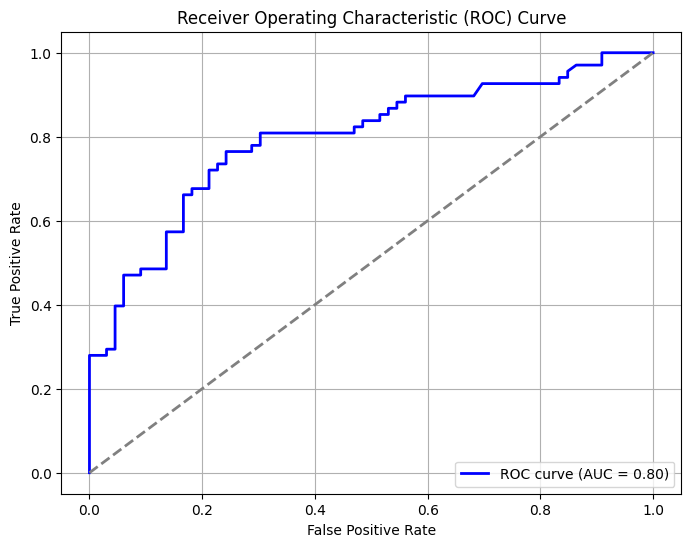

In [3]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
# Compute ROC curve and AUC score
all_probs = []  # Store probabilities for ROC
model.eval()
with torch.no_grad():
    for embeddings, _ in test_loader:
        embeddings = embeddings.to(device)
        outputs = model(embeddings).squeeze()
        all_probs.extend(outputs.cpu().numpy())  # Store probabilities

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = roc_auc_score(all_labels, all_probs)

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)  # Index where TPR - FPR is maximized
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="blue", lw=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=2)
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


<h1> Confusion Matrix </h1>

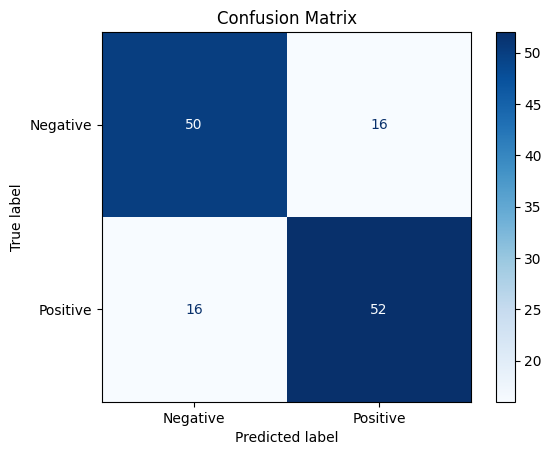

In [6]:
# # Compute confusion matrix
# threshold = 0.55  # Use the same threshold as during evaluation
# predictions = (torch.tensor(all_probs) >= threshold).numpy()
# cm = confusion_matrix(all_labels, predictions)

# # Plot Confusion Matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
# disp.plot(cmap="Blues")
# plt.title("Confusion Matrix")
# plt.grid(False)
# plt.show()
import numpy as np
# Classification using the optimal threshold
predicted_labels = (np.array(all_probs) >= optimal_threshold).astype(int)

# Compute and display the confusion matrix
cm = confusion_matrix(all_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
#OLD ROC CODE
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc
# import torch
# import numpy as np
# import pickle

# # Assuming embedding_paths contains a list of paths to pickle files
# # Example: embedding_paths = ["path/to/embedding1.pkl", "path/to/embedding2.pkl", ...]

# # Assuming `all_labels` contains the corresponding true labels

# # Prepare the input data and model outputs
# model_outputs = []
# true_labels = []

# # Loop through each embedding file in embedding_paths
# for embedding_path, true_label in zip(embedding_paths, all_labels):
#     # Load embedding from pickle file
#     with open(embedding_path, 'rb') as f:
#         input_data = pickle.load(f)  # Ensure the shape is (1, 768)
    
#     # Convert input_data to a torch tensor and move to the appropriate device
#     input_data = torch.tensor(input_data, dtype=torch.float32).to(device)
    
#     # Get the model's prediction (probability after sigmoid)
#     with torch.no_grad():  # Ensure no gradients are calculated
#         model_output = torch.sigmoid(model(input_data)).cpu().numpy()
    
#     # Append model output and true label
#     model_outputs.append(model_output.flatten())  # Flatten to match the true_labels format
#     true_labels.append(true_label)

# # Convert lists to numpy arrays
# model_outputs = np.array(model_outputs).flatten()  # Flatten the array to match the shape of true_labels
# true_labels = np.array(true_labels)

# # Compute ROC curve
# fpr, tpr, thresholds = roc_curve(true_labels, model_outputs)

# # Calculate AUC
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Curve')
# plt.legend(loc='lower right')
# plt.show()

# # Optionally: Find threshold that maximizes TPR and minimizes FPR (or another criterion)
# # You can choose a threshold based on your preference for reducing false negatives
# threshold_index = np.argmax(tpr - fpr)  # Can also optimize based on other metrics
# optimal_threshold = thresholds[threshold_index]
# print(f"Optimal threshold for reducing false negatives: {optimal_threshold:.2f}")


In [5]:
# # COPY of MAIN WORKING CODE
# device = torch.device("cuda") # or cpu
# # Define a custom dataset to load image embeddings and labels
# class EmbeddingsDataset(Dataset):
#     def __init__(self, embeddings_paths, labels):
#         self.embeddings_paths = embeddings_paths  # List of paths to pickle files
#         self.labels = labels  # List of labels (1 or 0)

#     def __len__(self):
#         return len(self.embeddings_paths)

#     def __getitem__(self, idx):
#         # Load embedding from pickle file
#         with open(self.embeddings_paths[idx], 'rb') as f:
#             embedding = pickle.load(f)
        
#         label = self.labels[idx]
#         return torch.tensor(embedding, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# # Define the MLP model
# class MLPClassifier(nn.Module):
#     def __init__(self, input_dim=768):  # Set input_dim to 768
#         super(MLPClassifier, self).__init__()
#         self.network = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, 1),
#             nn.Sigmoid()
#         )


#     def forward(self, x):
#         return self.network(x)

# # Load your data
# # Example paths and labels for illustration
# data = pd.read_csv('/mnt/storage/deva/BreastCancer_GeneticMutation/combined.csv')
# embedding_paths = data['file_path'].tolist()
# labels = data['label'].tolist()



# # Create dataset and data loader
# dataset = EmbeddingsDataset(embedding_paths, labels)
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# # Initialize model, loss, and optimizer
# input_dim = dataset[0][0].shape[0]  # Assuming all embeddings have the same dimension
# model = MLPClassifier(input_dim=768).to(device=device)
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)


# # Split data into training and test sets
# train_paths, test_paths, train_labels, test_labels = train_test_split(embedding_paths, labels, test_size=0.2, random_state=42)

# # Create datasets and data loaders for training and testing
# train_dataset = EmbeddingsDataset(train_paths, train_labels)
# test_dataset = EmbeddingsDataset(test_paths, test_labels)

# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# # Training loop (use train_loader for training)
# num_epochs = 8
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0
#     for embeddings, labels in train_loader:
#         embeddings, labels = embeddings.to(device=device), labels.to(device=device)
#         optimizer.zero_grad()
#         outputs = model(embeddings).squeeze()
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader)}")

# # Evaluation (use test_loader for evaluation)
# model.eval()
# all_labels = []
# all_preds = []
# with torch.no_grad():
#     for embeddings, labels in test_loader:
#         embeddings = embeddings.to(device=device)
#         outputs = model(embeddings).squeeze()
#         preds = (outputs >= 0.55).float()  # Convert probabilities to 0 or 1 predictions
#         # Use the optimal threshold to classify predictions
#         # predictions = (model_outputs >= 0.62).astype(int)  # 1 if >= 0.62, else 0
#         all_labels.extend(labels.cpu().numpy())
#         all_preds.extend(preds.cpu().numpy())

# accuracy = accuracy_score(all_labels, all_preds)
# print(f"Test accuracy: {accuracy * 100:.2f}%")


In [ ]:
# #above part is the working code, this part is to visualize train and validation loss curves
# import matplotlib.pyplot as plt

# # Initialize lists to store loss values
# train_losses = []
# val_losses = []
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
# # Training loop
# num_epochs = 6
# for epoch in range(num_epochs):
#     model.train()
#     total_train_loss = 0
#     for embeddings, labels in train_loader:
#         embeddings, labels = embeddings.to(device=device), labels.to(device=device)
#         optimizer.zero_grad()
#         outputs = model(embeddings).squeeze()
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         total_train_loss += loss.item()
    
#     # Average training loss for the current epoch
#     avg_train_loss = total_train_loss / len(train_loader)
#     train_losses.append(avg_train_loss)
    
#     # Validation loop
#     model.eval()
#     total_val_loss = 0
#     with torch.no_grad():
#         for embeddings, labels in test_loader:
#             embeddings, labels = embeddings.to(device=device), labels.to(device=device)
#             outputs = model(embeddings).squeeze()
#             loss = criterion(outputs, labels)
#             total_val_loss += loss.item()
            
    
#     # Average validation loss for the current epoch
#     avg_val_loss = total_val_loss / len(test_loader)
#     val_losses.append(avg_val_loss)
#     scheduler.step(avg_val_loss)
#     # Print losses for current epoch
#     print(f"Epoch [{epoch+1}/{num_epochs}], "
#           f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# # Plot the training and validation loss curves
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', color='blue')
# plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='red')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()


<h1>Training, Validation, Loss Plotting, and Accuracy Evaluation</h1>

In [5]:
# # Training and Validation Loop with Early Stopping
# num_epochs = 10
# for epoch in range(num_epochs):
#     model.train()
#     total_train_loss = 0
#     for embeddings, labels in train_loader:
#         embeddings, labels = embeddings.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(embeddings).squeeze()
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         total_train_loss += loss.item()
#     avg_train_loss = total_train_loss / len(train_loader)
#     train_losses.append(avg_train_loss)

#     # Validation
#     model.eval()
#     total_val_loss = 0
#     all_labels = []
#     all_preds = []
#     with torch.no_grad():
#         for embeddings, labels in test_loader:
#             embeddings, labels = embeddings.to(device), labels.to(device)
#             outputs = model(embeddings).squeeze()
#             loss = criterion(outputs, labels)
#             total_val_loss += loss.item()

#             # Accuracy-related predictions
#             preds = (outputs >= 0.50).float()
#             all_labels.extend(labels.cpu().numpy())
#             all_preds.extend(preds.cpu().numpy())

#     avg_val_loss = total_val_loss / len(test_loader)
#     val_losses.append(avg_val_loss)
#     scheduler.step(avg_val_loss)
    
#     # Epoch summary
#     accuracy = accuracy_score(all_labels, all_preds)
#     print(f"Epoch [{epoch+1}/{num_epochs}], "
#           f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, "
#           f"Accuracy: {accuracy * 100:.2f}%")
    
#     # Early Stopping
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         epochs_no_improve = 0
#         torch.save(model.state_dict(), "best_model.pth")  # Save the best model
#     else:
#         epochs_no_improve += 1
#         if epochs_no_improve == patience:
#             print(f"Early stopping triggered at epoch {epoch + 1}!")
#             break

# # Plot Loss Curves
# epochs_completed = len(train_losses)  # Use the actual number of completed epochs
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, epochs_completed + 1), train_losses, label='Training Loss', color='blue')
# plt.plot(range(1, epochs_completed + 1), val_losses, label='Validation Loss', color='red')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()


In [12]:
embedding_paths = data['file_path'].tolist()  # List of paths to pickle files
print(f"Embedding paths length: {len(embedding_paths)}")  # Should be 669

# Load all embeddings and check their length
embeddings_cpu = []
for path in embedding_paths:
    with open(path, 'rb') as f:
        embedding = pickle.load(f)
        embeddings_cpu.append(embedding)
print(f"Length of embeddings: {len(embeddings_cpu)}")  # Should be 669


Embedding paths length: 669


/home/dravich6/miniconda3/envs/MedCT/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Length of embeddings: 669


<h1>UMap</h1>

/home/dravich6/miniconda3/envs/MedCT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-19 11:26:34.917500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732040794.983133  681600 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732040795.002344  681600 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 11:26:35.151580: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-

Shape of embeddings array: (669, 768)
Shape of labels array: (669,)


/home/dravich6/miniconda3/envs/MedCT/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


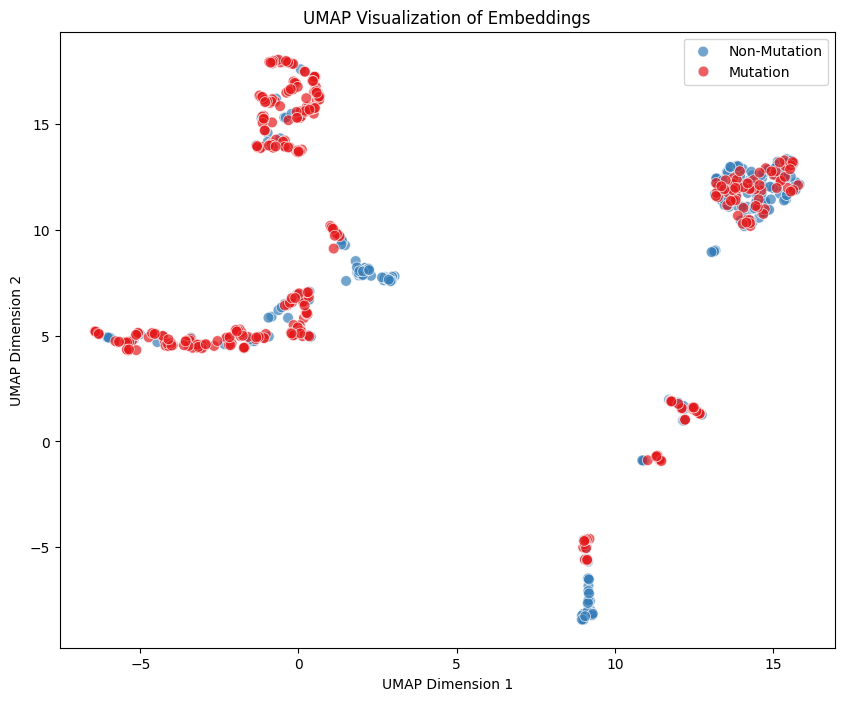

In [7]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import umap
import seaborn as sns
import numpy as np

# Collect all embeddings and labels
embeddings_list = []
labels_list = []

for embedding, label in dataset:
    embeddings_list.append(embedding.squeeze().cpu().numpy())  # Squeeze to remove extra dimension and move to CPU
    labels_list.append(label.item())  # Convert tensor label to a scalar value

# Convert to numpy arrays for UMAP
embeddings_array = np.array(embeddings_list)
labels_array = np.array(labels_list)

print(f"Shape of embeddings array: {embeddings_array.shape}")  # Should be (669, 768)
print(f"Shape of labels array: {labels_array.shape}")  # Should be (669,)

# Initialize UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)

# Fit the UMAP model and transform the embeddings
embeddings_2d_umap = umap_model.fit_transform(embeddings_array)

# Plotting the UMAP results with a distinguishable color palette
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d_umap[:, 0], y=embeddings_2d_umap[:, 1], hue=labels_array, palette="Set1", s=60, alpha=0.7)
plt.title("UMAP Visualization of Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(["Non-Mutation", "Mutation"])
plt.show()


<h1>Updated ROC and Threshold Selection</h1>

In [38]:
# Use the optimal threshold to classify predictions
predictions = (model_outputs >= optimal_threshold).astype(int)  # 1 if >= 0.62, else 0


In [7]:
#confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Assuming predictions and true_labels are your new predicted and ground truth labels
# cm = confusion_matrix(true_labels, predictions)
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Classification report (including precision, recall, F1-score)
# report = classification_report(true_labels, predictions)
report = classification_report(all_labels, all_preds)
print("Classification Report:\n", report)


Confusion Matrix:
 [[51 15]
 [19 49]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.77      0.75        66
         1.0       0.77      0.72      0.74        68

    accuracy                           0.75       134
   macro avg       0.75      0.75      0.75       134
weighted avg       0.75      0.75      0.75       134



In [29]:
# print(f"Length of predicted outputs: {len(model_outputs)}")
# print(f"Length of true labels: {len(true_labels)}")

Length of predicted outputs: 7
Length of true labels: 134


In [39]:
# # Assuming the file paths are stored in the `embedding_paths` column of the DataFrame
# embedding_paths = data['file_path'].tolist()  # List of paths to pickle files

# # Verify the length of embedding_paths matches the labels
# print(f"Length of embedding_paths: {len(embedding_paths)}")
# print(f"Length of labels: {len(labels)}")

# # Load the embeddings correctly
# embeddings_cpu = []
# for path in embedding_paths:
#     with open(path, 'rb') as f:
#         embedding = pickle.load(f)
#         embeddings_cpu.append(embedding)

# print(f"Length of embeddings: {len(embeddings_cpu)}")  # Should be 669


In [25]:
# import umap.umap_ as umap
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Assuming embeddings is a list of embeddings on the CPU as numpy arrays
# # embeddings_cpu = [embedding.cpu().numpy().squeeze() for embedding in embeddings]  # squeeze to remove extra dimension

# # Run UMAP
# umap_model = umap.UMAP(n_components=2, random_state=42)
# embeddings_umap_2d = umap_model.fit_transform(embeddings_cpu)

# # Plotting
# plt.figure(figsize=(10, 8))
# sns.scatterplot(x=embeddings_umap_2d[:, 0], y=embeddings_umap_2d[:, 1], hue=labels, palette="viridis", s=60, alpha=0.7)
# plt.title("UMAP Visualization of Embeddings")
# plt.xlabel("UMAP Dimension 1")
# plt.ylabel("UMAP Dimension 2")
# plt.legend(["Non-Mutation", "Mutation"])
# plt.show()



In [6]:
# print(f"Length of embeddings: {len(embeddings_cpu)}")
# print(f"Length of labels: {len(labels)}")

Length of embeddings: 6
Length of labels: 669


In [38]:
# import tensorflow as tf
# import numpy as np

# # Assuming embeddings is a PyTorch tensor on a CUDA device
# embeddings_cpu = embeddings.cpu().numpy()  # Move embeddings to CPU and convert to NumPy
# labels_tensor = np.array(labels)  # Convert labels to NumPy array (TensorFlow can work with NumPy)

# # Convert embeddings and labels to TensorFlow tensors
# embeddings_tensor = tf.Variable(embeddings_cpu)
# labels_tensor = tf.constant(labels_tensor)

# # Save embeddings and metadata
# checkpoint = tf.train.Checkpoint(embedding=embeddings_tensor)
# checkpoint.save("/mnt/storage/deva/BreastCancer_GeneticMutation/embeddings.ckpt")

# # Save metadata (labels)
# with open("/mnt/storage/deva/BreastCancer_GeneticMutation/metadata.tsv", "w") as f:
#     f.write("Label\n")  # header for metadata file
#     for label in labels:
#         f.write(f"{label}\n")


In [35]:
# import umap
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming embeddings is a PyTorch tensor, move it to CPU and convert to NumPy
# embeddings_cpu = embeddings.cpu().numpy()  # Move embeddings to CPU and convert to NumPy

# # If your embeddings are 3D (e.g., batch_size x embedding_dim), flatten them to 2D
# # The shape should be (number_of_embeddings, embedding_dimension)
# # For example, if embeddings has shape (batch_size, embedding_dim), reshape it as follows:
# # If the embeddings have shape (batch_size, embedding_dim), we don't need to reshape
# # If embeddings have more dimensions, e.g., (batch_size, channels, height, width), then reshape accordingly

# # Flatten embeddings if they are 3D or 4D (you can reshape to 2D)
# if len(embeddings_cpu.shape) > 2:
#     embeddings_cpu = embeddings_cpu.reshape(embeddings_cpu.shape[0], -1)  # Flatten to 2D

# # Perform UMAP dimensionality reduction to 2D
# umap_model = umap.UMAP(n_components=2, random_state=42)
# umap_embeddings = umap_model.fit_transform(embeddings_cpu)

# # Assuming you have labels to color the points
# labels_array = np.array(labels)  # Ensure labels are in a NumPy array

# # Plot the UMAP embeddings
# plt.figure(figsize=(10, 8))
# plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels_array, cmap='viridis', alpha=0.7)
# plt.colorbar(label='Label')  # Display a colorbar for the labels
# plt.title('UMAP projection of embeddings')
# plt.xlabel('UMAP1')
# plt.ylabel('UMAP2')
# plt.show()


In [ ]:
# # pip install tensorflow
# !pip install umap-learn
# pip uninstall numpy
# pip install numpy==1.21.6

In [ ]:
# # Check the shape of a single embedding and the total number of samples
# embedding_sample, label_sample = dataset[0]  # Take the first sample
# print(f"Shape of a single embedding: {embedding_sample.shape}")
# print(f"Total number of samples: {len(dataset)}")

# # Inspect the labels as well
# print(f"Labels sample: {label_sample}")


<h1> t SNE </h1>

/home/dravich6/miniconda3/envs/MedCT/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/tmp/i

Shape of embeddings array: (669, 768)
Shape of labels array: (669,)


/home/dravich6/miniconda3/envs/MedCT/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


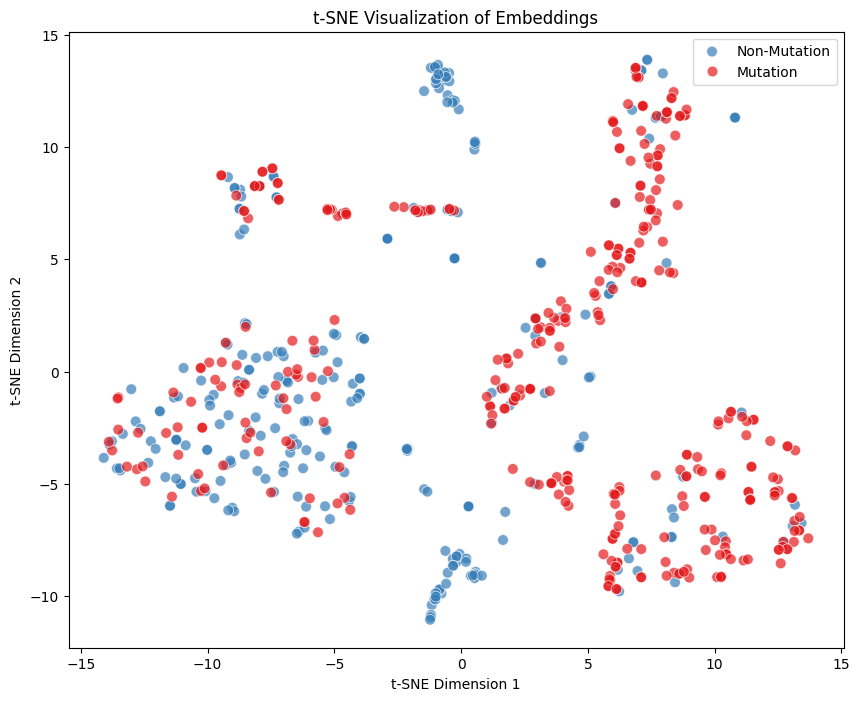

In [24]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns

# Collect all embeddings and labels
embeddings_list = []
labels_list = []

for embedding, label in dataset:
    embeddings_list.append(embedding.squeeze().cpu().numpy())  # Squeeze to remove extra dimension and move to CPU
    labels_list.append(label.item())  # Convert tensor label to a scalar value

# Convert to numpy arrays for t-SNE
embeddings_array = np.array(embeddings_list)
labels_array = np.array(labels_list)

print(f"Shape of embeddings array: {embeddings_array.shape}")  # Should be (669, 768)
print(f"Shape of labels array: {labels_array.shape}")  # Should be (669,)

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
embeddings_2d = tsne.fit_transform(embeddings_array)

# Plotting the t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels_array, palette="Set1", s=60, alpha=0.7)
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(["Non-Mutation", "Mutation"])
plt.show()


<h1> Class Distribution </h1>

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming labels is a list of 0s and 1s
# Convert the labels list to a DataFrame for easier plotting
labels_df = pd.DataFrame(labels, columns=["label"])

# Count the occurrences of each class
class_counts = labels_df['label'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.xlabel("Class (0 = Non-Mutation, 1 = Mutation)")
plt.ylabel("Frequency")
plt.title("Class Distribution in Dataset")
plt.xticks([0, 1], ["Non-Mutation", "Mutation"])
plt.show()

In [11]:
import pandas as pd
import pickle
import numpy as np
import torch  # Ensure PyTorch is imported in case embeddings are tensors

# Load the CSV file
csv_file = '/mnt/storage/deva/BreastCancer_GeneticMutation/combined.csv'
data = pd.read_csv(csv_file)

# Placeholder for embeddings and labels
embeddings_list = []
labels_list = []

# Iterate through the CSV file to load embeddings
for idx, row in data.iterrows():
    file_path = row['file_path']
    label = row['label']
    try:
        with open(file_path, 'rb') as f:
            embedding = pickle.load(f)  # Load embedding from pickle file

            # If the embedding is on GPU (cuda), move it to CPU
            if isinstance(embedding, torch.Tensor) and embedding.is_cuda:
                embedding = embedding.cpu()

            # Convert tensor to numpy array if necessary and flatten it
            embeddings_list.append(embedding.flatten().numpy() if isinstance(embedding, torch.Tensor) else embedding)
            labels_list.append(label)
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")

# Convert the embeddings list into a NumPy array
embeddings_array = np.array(embeddings_list)

# Convert embeddings and labels into a DataFrame
tsv_data = pd.DataFrame(embeddings_array)
tsv_data['label'] = labels_list  # Add the labels as the last column

# Save to TSV file
tsv_file = '/mnt/storage/deva/BreastCancer_GeneticMutation/embeddings_visualization.tsv'
tsv_data.to_csv(tsv_file, sep='\t', index=False, header=False)

print(f"TSV file saved to: {tsv_file}")


/home/dravich6/miniconda3/envs/MedCT/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


TSV file saved to: /mnt/storage/deva/BreastCancer_GeneticMutation/embeddings_visualization.tsv


/home/dravich6/miniconda3/envs/MedCT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-19 15:48:24.659282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732056504.671640  746819 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732056504.675504  746819 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 15:48:24.689102: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-

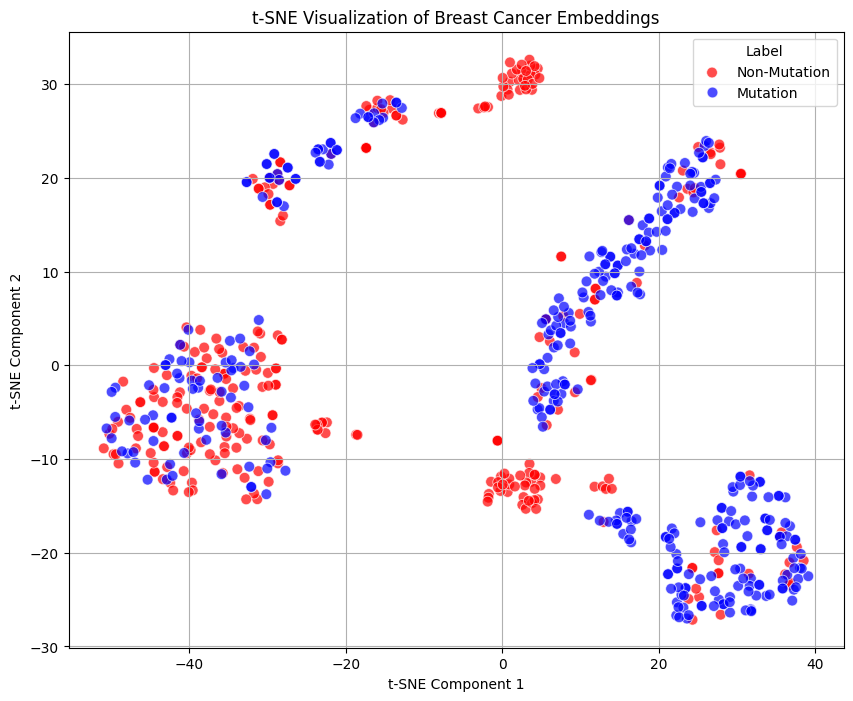

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import seaborn as sns

# Load the TSV file with embeddings and labels
tsv_file = '/mnt/storage/deva/BreastCancer_GeneticMutation/embeddings_visualization.tsv'
data = pd.read_csv(tsv_file, sep='\t', header=None)

# Extract embeddings and labels
embeddings = data.iloc[:, :-1].values  # All columns except the last (embedding features)
labels = data.iloc[:, -1].values  # Last column (label)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

# Perform UMAP (optional)
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(embeddings)

# Create the plot using t-SNE or UMAP
plt.figure(figsize=(10, 8))

# Use Seaborn's color palette for better visualization
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette={0: 'blue', 1: 'red'}, s=60, alpha=0.7)

# Alternatively, use UMAP result
# sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=labels, palette={0: 'blue', 1: 'red'}, s=60, alpha=0.7)

# Customize plot
plt.title('t-SNE Visualization of Breast Cancer Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Label', labels=['Non-Mutation', 'Mutation'])
plt.grid(True)
plt.show()
